### Corrective RAG

In [1]:
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from typing import List
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.output_parsers import StrOutputParser

from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

import os
from dotenv import load_dotenv
load_dotenv(override=True)

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [2]:
embedding_function = OpenAIEmbeddings()

docs = [
    Document(
        page_content="鼎泰豐由楊秉彝與妻子賴盆妹於1958年在台北創立，最初是販售食用油的小店。1972年轉型為餐廳，以小籠包聞名。現已成為國際知名的台灣美食品牌，在全球多個國家設有分店。",
        metadata={"source": "restaurant_history.txt"},
    ),
    Document(
        page_content="鼎泰豐的小籠包以18摺聞名，每個摺都代表著精湛的手藝。小籠包皮薄餡多，內有鮮美湯汁，是鼎泰豐最受歡迎的招牌菜品。每天現場手工製作，確保新鮮品質。",
        metadata={"source": "signature_dish.txt"},
    ),
    Document(
        page_content="鼎泰豐菜單豐富多樣，除了招牌小籠包外，還有蝦仁燒賣、雞湯餛飩、菜肉餛飩、排骨煨麵、韭黃蝦仁、蛋炒飯等經典菜色。素食選擇包括素小籠包、素蒸餃和各式蔬菜料理。",
        metadata={"source": "menu_items.txt"},
    ),
    Document(
        page_content="鼎泰豐的價格範圍適中，滿足不同消費需求。小籠包每籠（10個）約180-220元，主菜價格從250元到500元不等。套餐選擇豐富，單人套餐約500-700元，雙人套餐約1000-1500元。",
        metadata={"source": "pricing_info.txt"},
    ),
    Document(
        page_content="鼎泰豐台北101旗艦店營業時間為週一至週五11:00-21:30，週六、日及國定假日10:00-21:30。其他分店可能略有不同，建議顧客查詢官網或致電確認。旺季時可能需要排隊等候。",
        metadata={"source": "operation_hours.txt"},
    ),
    Document(
        page_content="鼎泰豐重視食材品質和衛生標準。所有食材每日新鮮配送，嚴格控管儲存溫度。廚房採用開放式設計，顧客可以直接觀看廚師製作過程，體現透明化的製作流程。",
        metadata={"source": "quality_control.txt"},
    ),
    Document(
        page_content="鼎泰豐的服務以親切周到聞名。工作人員接受嚴格培訓，能夠用多國語言服務國際顧客。餐廳內部裝潢簡約現代，保持整潔舒適的用餐環境。",
        metadata={"source": "service_ambiance.txt"},
    ),
    Document(
        page_content="鼎泰豐曾獲得米其林一星評鑑，是台灣首家進入米其林指南的餐廳。它也多次被國際媒體評為世界最佳餐廳之一，成為台灣美食外交的重要代表。",
        metadata={"source": "awards_recognition.txt"},
    ),
    Document(
        page_content="鼎泰豐除了堂食，也提供外帶服務。部分分店與外送平台合作，提供送餐到府服務。公司也有自營的線上商店，販售冷凍小籠包等產品，讓顧客在家也能享受鼎泰豐美味。",
        metadata={"source": "services_products.txt"},
    ),
    Document(
        page_content="鼎泰豐重視永續經營，積極採取環保措施。使用可回收包裝材料，推廣減塑行動。同時也參與社會公益，定期舉辦愛心餐會，回饋社會。",
        metadata={"source": "sustainability_csr.txt"},
    ),
]

db = Chroma.from_documents(docs, embedding_function)
retriever = db.as_retriever()

In [3]:
# State
class AgentState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    question: str
    generation: str
    web_search: str
    documents: List[str]

### 問題評分器

In [4]:
class GradeQuestion(BaseModel):
    """用於檢查問題是否與鼎泰豐餐廳有關"""
    binary_score: str = Field(
        description="問題是否與餐廳有關? 如果是 -> 'yes' 如果不是 -> 'no'"
    )

system = """你是一個評分員,負責評估檢索到的文件與用戶問題的相關性。
只有當問題是關於以下主題時才回答:
1. 鼎泰豐的歷史和創始人資訊
2. 鼎泰豐的菜單和特色菜品
3. 鼎泰豐的價格範圍
4. 鼎泰豐的營業時間和地點
5. 鼎泰豐的用餐體驗和服務

如果問題是關於這些主題,請回答"yes",否則回答"no"。"""

grade_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "user question: {question}")])

llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm = llm.with_structured_output(GradeQuestion)
retrieval_grader = grade_prompt | structured_llm

#測試
docs = retriever.get_relevant_documents("鼎泰豐有賣湯包嗎?")
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": "鼎泰豐有賣湯包嗎?", "document": doc_txt}))

/var/folders/yw/v6fz89fx5pd827bs1070ywr00000gn/T/ipykernel_73532/202964097.py:26: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents("鼎泰豐有賣湯包嗎?")


binary_score='yes'


### Retrieval Evaluator

In [5]:
class GradeDocuments(BaseModel):
    """用於檢查檢索到的文檔是否相關。"""

    score: str = Field(
        description="文檔是否與問題相關，'是' 或 '否'"
    )

# 定義 LLM 呼叫流程
system = """你是一個評分員，負責評估檢索到的文檔與用戶問題的相關性。
如果文檔包含與問題相關的關鍵詞或語義含義，請將其評為相關。
給出評分 '是' 或 '否' 來表示文檔是否與問題相關。"""

grade_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "Retrieved document: \n\n {document} \n\n User question: {question}")])

llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm = llm.with_structured_output(GradeDocuments)
docs_grader_llm = grade_prompt | structured_llm

result = docs_grader_llm.invoke({
    "document": "鼎泰豐菜單豐富多樣，包括招牌小籠包、各式點心、湯品、炒飯麵、蔬菜等。",
    "question": "鼎泰豐在哪裡？"})
print(result)

score='否'


### Question Re-write

In [6]:
# 定義 LLM 呼叫流程
system = """你是一個問題重寫器，負責將輸入的問題轉換成更適合檢索的優化版本。
分析輸入問題，試圖理解其潛在的語義意圖和含義。
特別注意與鼎泰豐餐廳相關的問題，包括但不限於：
1. 鼎泰豐的歷史和創始人資訊
2. 鼎泰豐的菜單和特色菜品
3. 鼎泰豐的價格範圍
4. 鼎泰豐的營業時間和地點
5. 鼎泰豐的用餐體驗和服務
請根據這些主題來優化問題。"""

re_write_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human","Here is the initial question: \n\n {question} \n Formulate an improved question.")]
)
llm = ChatOpenAI(model="gpt-4o", temperature=0)
question_rewriter = re_write_prompt | llm | StrOutputParser()

# 測試 Agent 運作狀況
result = question_rewriter.invoke({"question": "鼎泰豐有賣湯包嗎?"})
print(result)

鼎泰豐的菜單上有提供湯包嗎？


### 問答 Agent

In [7]:
template = """Answer the question based only on the following context:{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template=template)
rag_chain = prompt | llm | StrOutputParser()

# 測試 Agent 運作狀況
generation = rag_chain.invoke({
    "question": "鼎泰豐有賣湯包嗎?",
    "context": "鼎泰豐的小籠包以皮薄餡多聞名，每個小籠包都有 18 個摺子，內餡使用精選豬肉，湯汁豐富。鼎泰豐堅持手工製作，確保每一顆小籠包都維持高品質。"
})
print(generation)

根據提供的資訊，鼎泰豐以小籠包聞名，並沒有提到湯包。因此，無法確定鼎泰豐是否有賣湯包。


## 網路檢索工具

In [8]:
web_search_tool = TavilySearchResults(k=3)

### 定義節點函數以及 Agent

In [9]:
def retrieve(state):
    print("--- RETRIEVE ---")
    question = state["question"]
    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


def generate(state):
    print("--- GENERATE ---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    print("--- CHECK DOCUMENT RELEVANCE TO QUESTION ---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("--- GRADE: DOCUMENT RELEVANT ---")
            filtered_docs.append(d)
        else:
            print("--- GRADE: DOCUMENT NOT RELEVANT ---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def transform_query(state):
    print("--- RE-WRITE QUERY ---")
    question = state["question"]
    documents = state["documents"]

    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    print("--- WEB SEARCH ---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}


### Edges
def decide_to_generate(state):
    print("--- ASSESS GRADED DOCUMENTS ---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        print("--- DECISION: Re-WRITE ---")
        return "transform_query"
    else:
        print("--- DECISION: GENERATE ---")
        return "generate"

### 構建圖

In [10]:
workflow = StateGraph(AgentState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

### 可視化整張圖

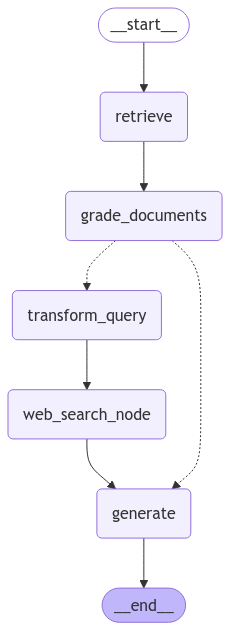

In [11]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

### Inference

In [14]:
result = app.invoke({"question": "你知道今年世界棒球 12 強賽排名是什麼？"})
result

--- RETRIEVE ---
--- CHECK DOCUMENT RELEVANCE TO QUESTION ---
--- GRADE: DOCUMENT NOT RELEVANT ---
--- GRADE: DOCUMENT NOT RELEVANT ---
--- GRADE: DOCUMENT NOT RELEVANT ---
--- GRADE: DOCUMENT NOT RELEVANT ---
--- ASSESS GRADED DOCUMENTS ---
--- DECISION: Re-WRITE ---
--- RE-WRITE QUERY ---
--- WEB SEARCH ---
--- GENERATE ---


{'question': '今年的世界棒球12強賽的最終排名是怎樣的？',
 'generation': '今年的世界棒球12強賽中，台灣隊奪得冠軍，最終排名第一。日本隊在冠軍賽中被台灣以4:0完封，位居第二。委內瑞拉則在12強賽中取得隊史最佳的第四名，排名上升到第三名。墨西哥未能進入四強複賽，排名被擠到第四名。',
 'web_search': 'Yes',
 'documents': [Document(metadata={}, page_content="台灣隊在世界12強棒球賽奪得佳績，最終冠軍賽以4:0完封日本，一舉拿下世界冠軍，寫下新歷史。對此，世界棒壘球總會 （WBSC）公布男子棒球世界最新排名，台灣隊位居第二，且與世界排名第一的日本隊差距再縮小。 ... 荷蘭聖馬丁在今年的第五屆加勒比海棒球\n12強世界棒球賽圓滿落幕，中華隊將士用命、擊敗日本奪下金牌，而世界棒壘球總會（wbsc）在公布最新的世界棒球排名，穩居首位的仍是日本，台灣\n世界12強》WBSC公布最新排名 中華隊奪冠積分進補！甩下墨西哥獨居世界第二 世界棒壘球總會（WBSC）今天（28日）公布最新棒球世界排名，中華隊在剛結束的12強賽抱走冠軍、積分大進補，也因此在最新一期的排名甩掉墨西哥，獨居世界第二。 世界12強棒球賽中華隊抱走冠軍金盃。圖片來源：中華棒協提供 國際三大賽事（經典賽、12強賽、奧運）之中，12強賽的積分最高，冠軍可進帳1380分，有些弔詭的是，強度更高的經典賽冠軍只有1150分，原因在於主導經典賽的MLB不放行40人名單球員參與12強賽，WBSC只好以積分差異反制。 根據WBSC官網發布的資訊，中華隊獲得冠軍後進帳1380分，全年積分增長2135分，僅次於日本的2449分，整體排名台灣甩掉原本並列的墨西哥、獨居第二，與龍頭日本的差距也從1638分縮小到1368分。 最新世界棒球排名。圖片來源：WBSC 墨西哥在本屆12強未能前進四強複賽，不只第二名位子不保，還被擠到第四名，另一支中南美洲強權委內瑞拉則在12強奪下隊史最佳的第四名，這也讓他們排名一口氣上升兩位，來到史上最好的第三名，而且自2021年6月以來，委內瑞拉從第11名上升到第3名。 下一屆世界棒球12強即將改制，除了原本就有參賽資格的世界前12名隊伍，還有8支球隊要打資格賽、爭奪4張正賽門票，多明尼加和澳洲打完本屆

In [13]:
result = app.invoke({"question": "鼎泰豐有賣小籠包嗎？"})
result

--- RETRIEVE ---
--- CHECK DOCUMENT RELEVANCE TO QUESTION ---
--- GRADE: DOCUMENT RELEVANT ---
--- GRADE: DOCUMENT RELEVANT ---
--- GRADE: DOCUMENT RELEVANT ---
--- GRADE: DOCUMENT RELEVANT ---
--- ASSESS GRADED DOCUMENTS ---
--- DECISION: GENERATE ---
--- GENERATE ---


{'question': '鼎泰豐有賣小籠包嗎？',
 'generation': '有，鼎泰豐有賣小籠包。小籠包是鼎泰豐最受歡迎的招牌菜品。',
 'web_search': 'No',
 'documents': [Document(metadata={'source': 'signature_dish.txt'}, page_content='鼎泰豐的小籠包以18摺聞名，每個摺都代表著精湛的手藝。小籠包皮薄餡多，內有鮮美湯汁，是鼎泰豐最受歡迎的招牌菜品。每天現場手工製作，確保新鮮品質。'),
  Document(metadata={'source': 'pricing_info.txt'}, page_content='鼎泰豐的價格範圍適中，滿足不同消費需求。小籠包每籠（10個）約180-220元，主菜價格從250元到500元不等。套餐選擇豐富，單人套餐約500-700元，雙人套餐約1000-1500元。'),
  Document(metadata={'source': 'services_products.txt'}, page_content='鼎泰豐除了堂食，也提供外帶服務。部分分店與外送平台合作，提供送餐到府服務。公司也有自營的線上商店，販售冷凍小籠包等產品，讓顧客在家也能享受鼎泰豐美味。'),
  Document(metadata={'source': 'menu_items.txt'}, page_content='鼎泰豐菜單豐富多樣，除了招牌小籠包外，還有蝦仁燒賣、雞湯餛飩、菜肉餛飩、排骨煨麵、韭黃蝦仁、蛋炒飯等經典菜色。素食選擇包括素小籠包、素蒸餃和各式蔬菜料理。')]}